#Computational Fluid Dynamics Solver


This workbook has the code for solving a simple Fluid Dynamics system. By "simple", I mean a 2D system that has no external forces (gravity is an external force). Additionally, the only boundary conditions supported are Dirichlet or Neumann (the derivative should be a constant, not a function of space or time). Moreover, this CFD solver uses the Pressure Poisson equation to solve the system. There is no energy or Temperature component but it could be easily added later on.


There are 4 classes that come together to solve the system. The step by step user interface to use the CFD solver is:
1. Create a space for simulation using the **Spacetime** class. This will include the length, breadth, number of discretizations for space and timestep for the simulation.
2. Create an object using **Fluid** class which contains all the fluid properties. Currently, there are only viscosity and density required.
3. Create **Boundary** objects for all different boundary types you will be using. For a lid-driven cavity system, you need Dirichlet boundary with velocity 0 for 3 sides and a fixed velocity for top. Pressure should have a Neumann boundary with 0 derivative at the 3 edges, and top will be Dirichlet boundary with value 0. This means we will need 3 different types of Boundary objects for a lid-driven cavity system. Using these objects, create 3 lists of 4 boundary objects each for the x-velocity, y-velocity, and pressure. They should be in the order left, right, top, bottom.
4. Next, create a **CFD_System** object using the space, fluid, and boundary lists created before. By default, the velocities, and pressure are 0 everywhere. Use the **SetUInitial, SetVInitial, or SetPInitial** methods to change the initial values.
5. Use the **initialize_boundaries()** method to initialize the boundary conditions given.
6. Now you can use the **update()** method to go forward 1 timestep in system. 
7. The **vis_quiver** and **vis_stream** visualize the system using quiver or streamplots. The last cell provides code to animate the system.



**References**

1. Owkes, M. (2020). A guide to writing your first CFD solver. Retrieved from https://www.montana.edu/mowkes/research/source-codes/GuideToCFD_2020_02_28_v2.pdf

2. Deshmukh, G. (2021) Computational Flow Dynamics using Python: Modeling Laminar Flow. Towards Data Science. Retrieved from https://towardsdatascience.com/computational-fluid-dynamics-using-python-modeling-laminar-flow-272dad1ebec


In [1]:
#import all the required libraries
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib inline
import sys

In [2]:
#Task 1: OOP code

class Spacetime:
  '''
  This class creates a space with a meshgrid.

  Attributes:
  x_len: size of space in x direction
  y_len: size of space in y direction
  nx: number of x discretizations
  ny: number of y discretizations
  dt: timestep
  dx: spatial step size for x direction
  dy: spatial step size for y direction
  x: vector of x-coordinates
  y: vector of y-coordinates
  X, Y: Meshgrid of x and y coordinates

  '''

  #initialize all the attributes
  def __init__(self, x_len, y_len, nx, ny, dt):
    self.x_len = x_len
    self.y_len = y_len
    self.nx = nx
    self.ny = ny
    self.dt = dt
    self.dx = x_len/(nx-1)
    self.dy = y_len/(ny-1)
    self.x = np.linspace(0, x_len, nx)
    self.y = np.linspace(0, y_len, ny)
    self.X, self.Y = np.meshgrid(self.x, self.y)


class Fluid:
  '''
  This class creates a fluid object with the given properties

  Attributes:
  rho: density
  nu: viscosity coefficient

  '''
  
  def __init__(self, rho, nu):
    self.rho = rho
    self.nu = nu


class Boundary:
  '''
  This class will contain the boundary conditions for each boundary

  Attributes:
  btype: Type of boundary, could be Dirichlet ("D") or Neumann ("N")
  bval: Value of boundary condition. Exact value for D and derivative value for 
  N
  '''

  def __init__(self, btype, bval):
    self.btype = btype
    self.bval = bval

class CFD_System:
  '''
  This class combines the Space and Fluid together to create a system.

  Attributes:
  space: This is the Spacetime object
  fluid: This is the Fluid object
  u: x-velocity
  v: y-velocity
  p: pressure
  uboundaries: a list of Boundary objects for x-velocity
  vboundaries: a list of Boundary objects for y-velocity
  pboundaries: a list of Boundary objects for pressure

  '''

  def __init__(self, space, fluid, uboundaries, vboundaries, pboundaries):
    self.space = space
    self.fluid = fluid
    self.u = np.zeros((space.ny, space.nx))
    self.v = np.zeros((space.ny, space.nx))
    self.p = np.zeros((space.ny, space.nx))
    self.uboundaries = uboundaries
    self.vboundaries = vboundaries
    self.pboundaries = pboundaries

  #initialize boundaries after initializing the attributes
  def initialize_boundaries(self):
    SetUBoundary()
    SetVBoundary()
    SetPBoundary()

  #method to change u if needed
  def SetUInitial(self, u):
    self.u = u

  #method to change v if needed
  def SetVInitial(self, v):
    self.v = v

  #method to change p if needed
  def SetPInitial(self, p):
    self.p = p

  #methods to reset the boundaries using boundary conditions given
  def SetUBoundary(self):

    #create separate variables for each side
    left = self.uboundaries[0]
    right = self.uboundaries[1]
    top = self.uboundaries[2]
    bottom = self.uboundaries[3]

    #check for boundary type
    if left.btype == "D":
      self.u[:, 0] = left.bval    #Dirichlet is direct value
    elif left.btype == "N":
      self.u[:, 0] = self.u[:, 1] - self.space.dx*left.bval
      #Neumann boundary requires u_(n+1) = dx*val + u_n where val is the value
      #of Neumann boundary condition
    
    if right.btype == "D":
      self.u[:, -1] = right.bval
    elif right.btype == "N":
      self.u[:, -1] = self.u[:, -2] + self.space.dx*right.bval
    
    if top.btype == "D":
      self.u[-1, :] = top.bval
    elif top.btype == "N":
      self.u[-1, :] = self.u[-2, :] + self.space.dy*top.bval
    
    if bottom.btype == "D":
      self.u[0, :] = bottom.bval
    elif bottom.btype == "N":
      self.u[0, :] = self.u[1, :] - self.space.dy*bottom.bval

  def SetVBoundary(self):
    left = self.vboundaries[0]
    right = self.vboundaries[1]
    top = self.vboundaries[2]
    bottom = self.vboundaries[3]
    if left.btype == "D":
      self.v[:, 0] = left.bval
    elif left.btype == "N":
      self.v[:, 0] = self.v[:, 1] - self.space.dx*left.bval
    
    if right.btype == "D":
      self.v[:, -1] = right.bval
    elif right.btype == "N":
      self.v[:, -1] = self.v[:, -2] + self.space.dx*right.bval
    
    if top.btype == "D":
      self.v[-1, :] = top.bval
    elif top.btype == "N":
      self.v[-1, :] = self.v[-2, :] + self.space.dy*top.bval
    
    if bottom.btype == "D":
      self.v[0, :] = bottom.bval
    elif bottom.btype == "N":
      self.v[0, :] = self.v[1, :] - self.space.dy*bottom.bval

  def SetPBoundary(self):
    left = self.pboundaries[0]
    right = self.pboundaries[1]
    top = self.pboundaries[2]
    bottom = self.pboundaries[3]
    if left.btype == "D":
      self.p[:, 0] = left.bval
    elif left.btype == "N":
      self.p[:, 0] = self.p[:, 1] - self.space.dx*left.bval
    
    if right.btype == "D":
      self.p[:, -1] = right.bval
    elif right.btype == "N":
      self.p[:, -1] = self.p[:, -2] + self.space.dx*right.bval
    
    if top.btype == "D":
      self.p[-1, :] = top.bval
    elif top.btype == "N":
      self.p[-1, :] = self.p[-2, :] + self.space.dy*top.bval
    
    if bottom.btype == "D":
      self.p[0, :] = bottom.bval
    elif bottom.btype == "N":
      self.p[0, :] = self.p[1, :] - self.space.dy*bottom.bval

  #function to take the first partial derivative of arrays
  def diff_1st_x(self, f, dx):
    return (f[1:-1, 2:] - f[1:-1,0:-2])/(2*dx) #central difference method
    #we ignore the boundaries

  def diff_1st_y(self, f, dy):
    return (f[2:, 1:-1] - f[0:-2,1:-1])/(2*dy) 

  #function to take the 2nd partial derivative of the arrays
  def diff_2nd_x(self, f, dx):
    return (
        # f(i-1,j) + 2*f(i,j) + f(i+1,j) (central difference method)
        (f[1:-1,0:-2] - 2*f[1:-1,1:-1] + f[1:-1,2:])
        /dx**2
        ) 
    #once again, we ignore the boundaries
    
  def diff_2nd_y(self, f, dy):
    return (
        # f(i,j-1) + 2*f(i,j) + f(i,j+1) 
        (f[0:-2,1:-1] - 2*f[1:-1,1:-1] + f[2:,1:-1])
        /dy**2
        )

  def laplacian(self, f, dx, dy):
    return (self.diff_2nd_x(f, dx) + 
            self.diff_2nd_y(f, dy))
  
  #method to perform the predictor step of our simulation
  def compute_vel_star(self, un, vn, dx, dy, dt):
    u_star = un.copy()
    v_star = vn.copy()
    nu = self.fluid.nu

    # Equation (7), Owkes (2020)
    u_star[1:-1,1:-1] = (nu * self.laplacian(un, dx, dy) -
                          (un[1:-1, 1:-1]*self.diff_1st_x(un,dx) + 
                            vn[1:-1, 1:-1]*self.diff_1st_y(un,dy))
                        )*dt + un[1:-1, 1:-1]

    # Equation (12), Owkes (2020)
    v_star[1:-1,1:-1] = (nu * self.laplacian(vn, dx, dy) -
                          (un[1:-1, 1:-1]*self.diff_1st_x(vn,dx) + 
                            vn[1:-1, 1:-1]*self.diff_1st_y(vn,dy))
                        )*dt + vn[1:-1, 1:-1]
    
    return u_star, v_star

  def get_b(self, u_star, v_star, dx, dy, dt):
    '''
    Right hand side of equation (6), Owkes (2020)
    '''
    # b comes from starred velocities, which have boundary
    # conditions (the starred velocity is just the velocity
    # without the influence of pressure, so it still maintains
    # the boundary conditions of the velocity),  
    # but b does not really have boundary conditions of its own.
    # (PS Important point is how the value is used in pressure_poisson function,
    # i.e., `b[1:-1, 1:-1]` or simply `b`)
    # b = np.zeros((ny, nx))

    # (Divergence of vector-valued function)
    rho = self.fluid.rho
    divergence_vel_star = (self.diff_1st_x(u_star,dx) + 
                          self.diff_1st_y(v_star,dy))
    # b[1:-1,1:-1] = (1*rho/dt) * divergence_vel_star
    b = (rho/dt) * divergence_vel_star

    return b
  
  #solve the pressure poisson equation
  def pressure_poisson(self, p, b, dx, dy):  
    pn = p.copy()

    # (pn(i-1,j) + pn(i+1,j)) * dy**2 
    term1 = (pn[1:-1,0:-2] + pn[1:-1,2:]) * dy**2
    # (pn(i,j-1) + pn(i,j+1)) * dx**2
    term2 = (pn[0:-2,1:-1] + pn[2:,1:-1]) * dx**2
    # term 3 is -b * dx^2  * dy^2
    term3 = -(b * (dx**2 * dy**2))

    p[1:-1,1:-1] = (
        (term1 + term2 + term3)
        / (2*(dx**2+dy**2))
    )

    return p
  
  #method for corrector step of the simulation
  def corrector_step(self, u_star, v_star, p, dx, dy, dt):
    rho = self.fluid.rho
    u = np.empty_like(u_star)
    v = np.empty_like(u_star)
    
    u[1:-1,1:-1] = (-dt/rho)*(self.diff_1st_x(p, dx)) + u_star[1:-1,1:-1]
    v[1:-1,1:-1] = (-dt/rho)*(self.diff_1st_y(p, dy)) + v_star[1:-1,1:-1]

    return u, v

  #update step
  def update(self):
    # save the original values in temporary variables
    un = self.u
    vn = self.v
    p = self.p
    dx = self.space.dx
    dy = self.space.dy
    dt = self.space.dt

    #predictor step: calculate starred velocities
    u_star, v_star = self.compute_vel_star(un, vn, dx, dy, dt)

    #solve Poisson's equation
    b = self.get_b(u_star, v_star, dx, dy, dt)
    self.p = self.pressure_poisson(p, b, dx, dy)

    self.SetPBoundary() #reset the boundary condition

    #corrector step: update velocities
    self.u, self.v = self.corrector_step(u_star, v_star, self.p, dx, dy, dt)
    #reset the boundaries
    self.SetUBoundary()
    self.SetVBoundary()
  
  def vis_quiver(self):
    X = self.space.X
    Y = self.space.Y
    u = self.u
    v = self.v
    p = self.p
    fig = plt.figure(figsize=(8,6), dpi=100)
    # plotting the pressure field as a contour
    plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
    plt.colorbar()
    # plotting the pressure field outlines
    plt.contour(X, Y, p, cmap=cm.viridis)
    # plotting velocity field
    plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
    plt.xlabel('X')
    plt.ylabel('Y');
    plt.show()
  
  def vis_stream(self):
    X = self.space.X
    Y = self.space.Y
    u = self.u
    v = self.v
    p = self.p
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
    plt.colorbar()
    plt.contour(X, Y, p, cmap=cm.viridis)
    plt.streamplot(X, Y, u, v)
    plt.xlabel('X')
    plt.ylabel('Y');
    plt.show()

In [3]:
#testing: initialize the system
rho = 1
nu = 0.1
cavity_space = Spacetime(2, 2, 51, 51, 0.001)
water_test = Fluid(rho, nu)

#boundary conditions
Dir_0 = Boundary("D", 0)
Dir_1 = Boundary("D", 1)
Neu_0 = Boundary("N", 0)

u_boundaries = [Dir_0, Dir_0, Dir_1, Dir_0]
v_boundaries = [Dir_0, Dir_0, Dir_0, Dir_0]
p_boundaries = [Neu_0, Neu_0, Dir_0, Neu_0]

cavity_test = CFD_System(cavity_space, water_test, u_boundaries, v_boundaries, 
                         p_boundaries)

<ipython-input-2-c322f7faa90c>:325: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, p, cmap=cm.viridis)


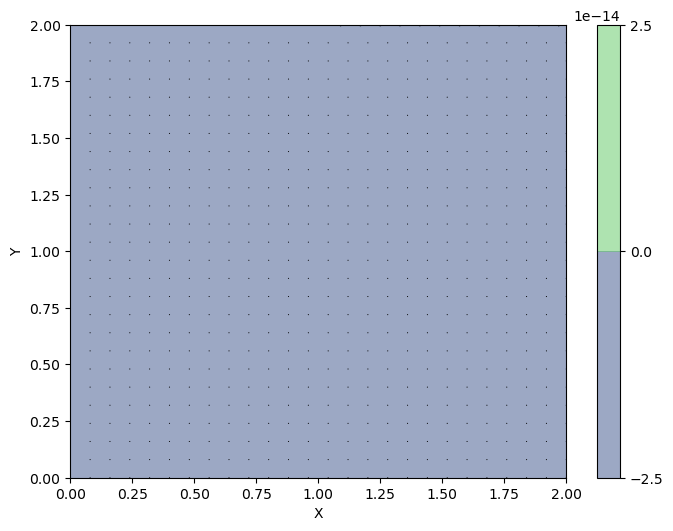

<ipython-input-2-c322f7faa90c>:341: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, p, cmap=cm.viridis)


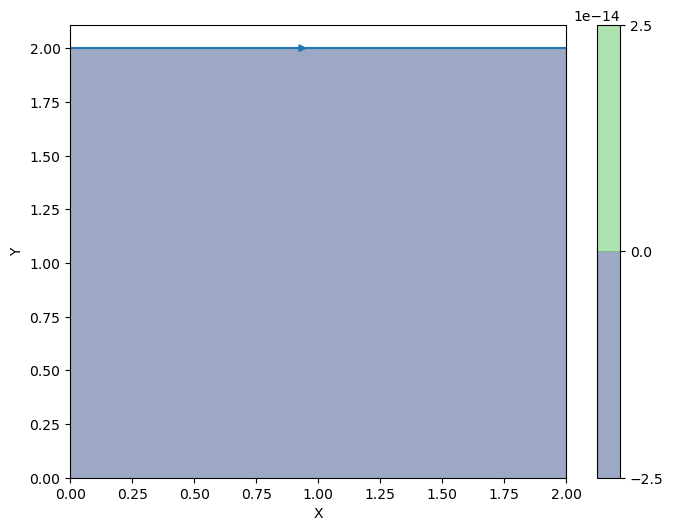

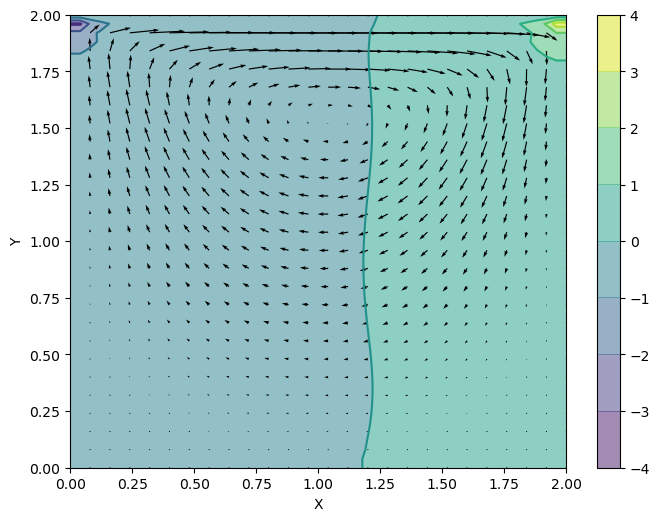

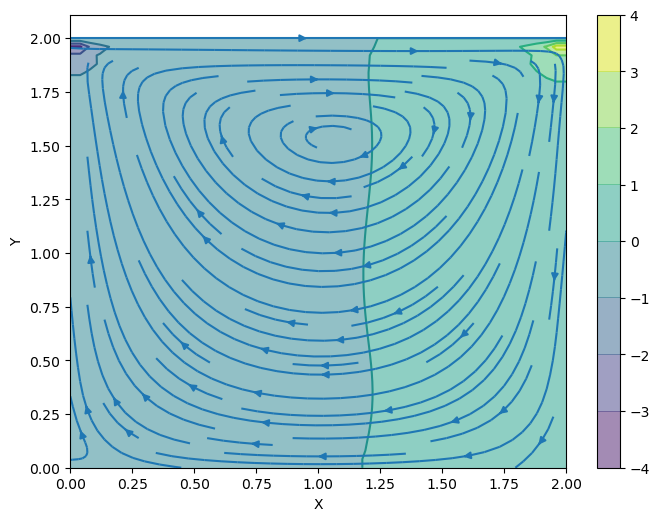

In [4]:
#testing: update the system and visualize

for i in range(1000):
  cavity_test.update()
  if i%999 == 0:
    cavity_test.vis_quiver()
    cavity_test.vis_stream()


<IPython.core.display.Javascript object>


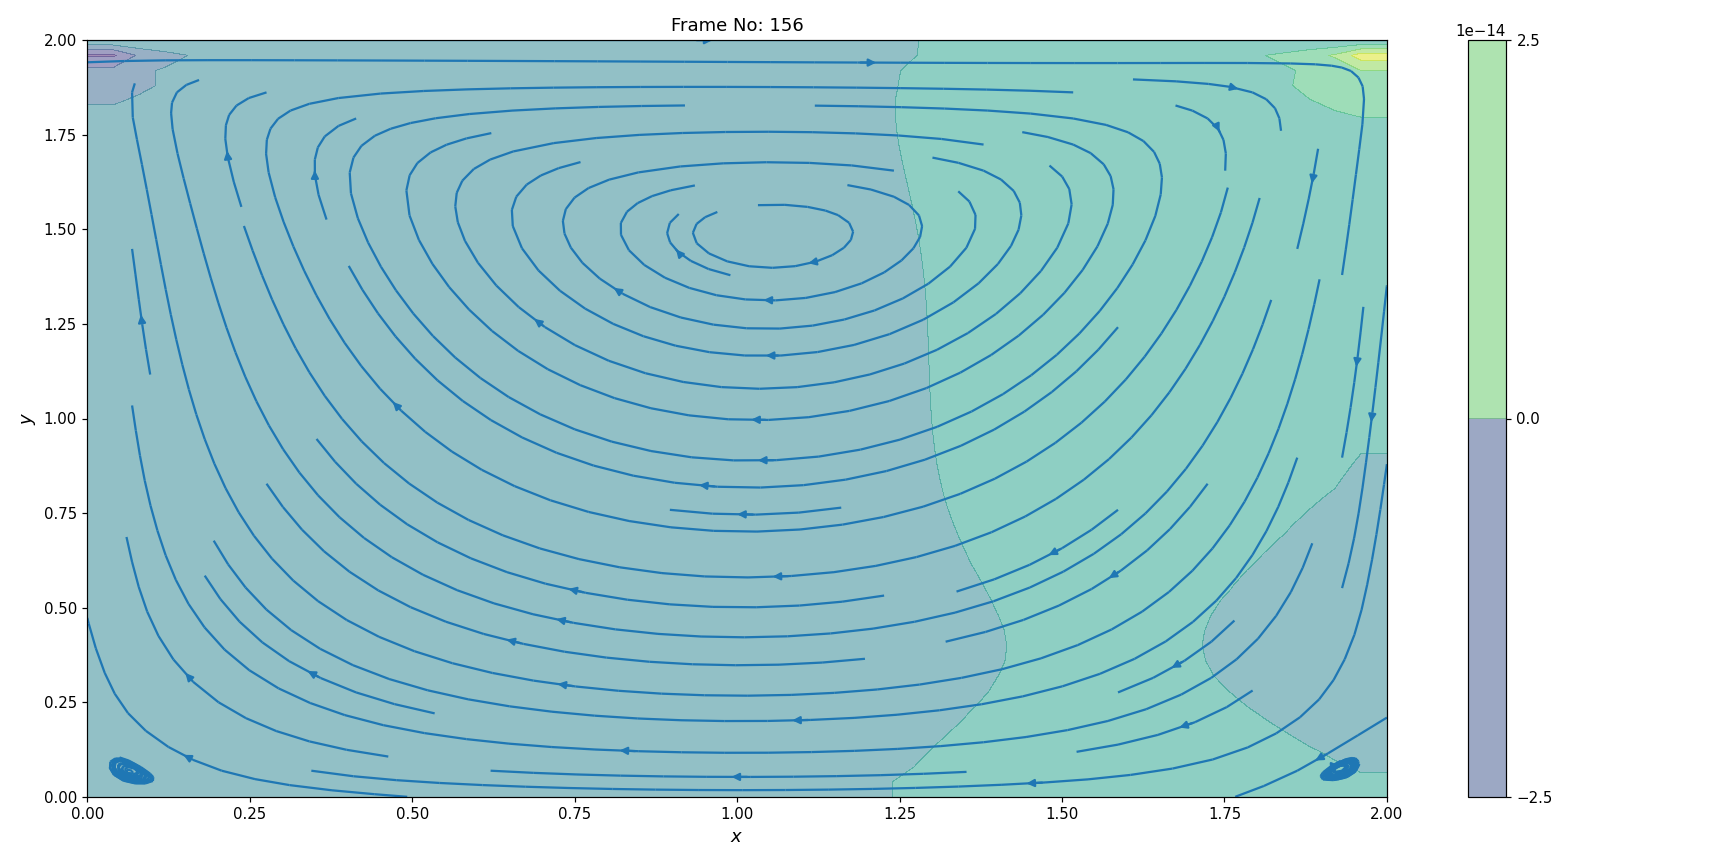

MovieWriter ffmpeg unavailable; using Pillow instead.


In [6]:
#Task 2 - Animation
#the simulation ran and will save automatically to the local drive
#two example simulations are included with the submission
#one with 100 iterations and another with 1000 (it took a long time)
#although the 1000 frames were useless since the system stabilized
#after about 550 frames

%matplotlib notebook

#initialize the system and create an object with the cavity
rho = 1
nu = 0.1
xl = 2
yl = 2
nx = 51
ny = 51
dt = 0.001
cavity_space = Spacetime(xl, yl, nx, ny, dt)
water_test = Fluid(rho, nu)

#boundary conditions
Dir_0 = Boundary("D", 0)
Dir_1 = Boundary("D", 1)
Neu_0 = Boundary("N", 0)

u_boundaries = [Dir_0, Dir_0, Dir_1, Dir_0]
v_boundaries = [Dir_0, Dir_0, Dir_0, Dir_0]
p_boundaries = [Neu_0, Neu_0, Dir_0, Neu_0]

cavity_test = CFD_System(cavity_space, water_test, u_boundaries, v_boundaries, 
                         p_boundaries)

#get initial values
u_i = cavity_test.u
v_i = cavity_test.v
p_i = cavity_test.p
X = cavity_space.X
Y = cavity_space.Y

#create an initial figure with contour, streamplot, and colorbar
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(xlim = (0, xl), ylim = (0, yl))
ax.set_xlabel("$x$",fontsize=12)
ax.set_ylabel("$y$",fontsize=12)
ax.set_title("Frame No: 0")
cont = ax.contourf(X, Y, p_i, alpha=0.5, cmap=cm.viridis)
stream = ax.streamplot(X, Y, u_i, v_i)
fig.colorbar(cont)
fig.tight_layout()

def animate(i, cavity):
  #Run the system for 10 steps between each frame
  for _ in range(10):
    cavity.update()

  #update the plot for animation
  u_p = cavity.u
  v_p = cavity.v
  p_p = cavity.p
  X = cavity.space.X
  Y = cavity.space.Y
  ax.clear()
  ax.set_xlim([0,xl])
  ax.set_ylim([0,yl])
  ax.set_xlabel("$x$",fontsize=12)
  ax.set_ylabel("$y$",fontsize=12)
  ax.set_title("Frame No: {0}".format(i))
  cont = ax.contourf(X, Y, p_p, alpha=0.5, cmap=cm.viridis)
  stream = ax.streamplot(X, Y, u_p, v_p)
  return cont, stream

frames = 1000
ani = animation.FuncAnimation(fig, animate, frames = frames, interval = 50, 
                              blit = False, fargs= [cavity_test])
ani.save("CFD_Simulation1.gif")

Vicosity =  0.1


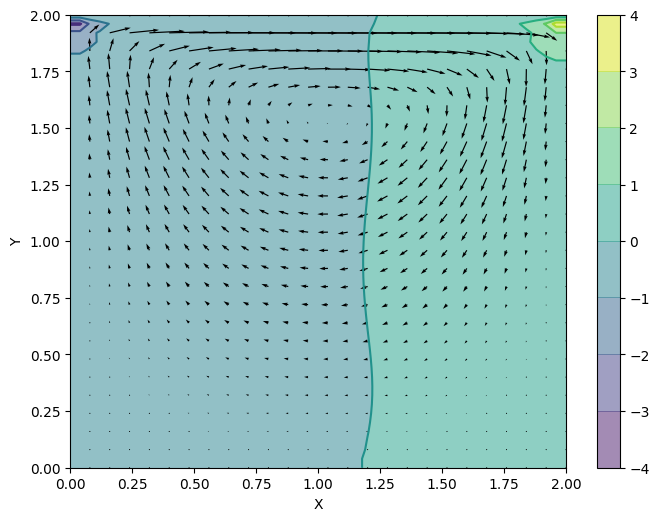

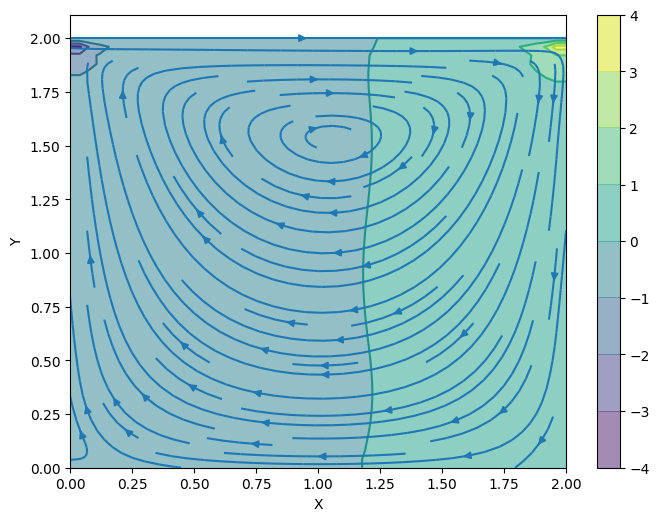

Vicosity =  0.05


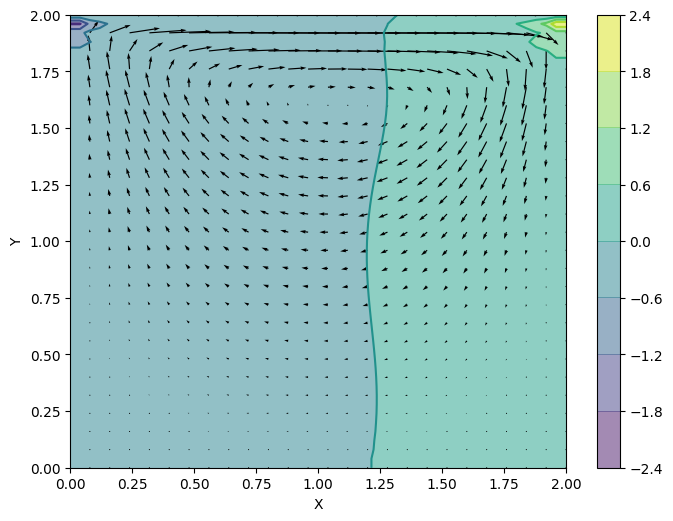

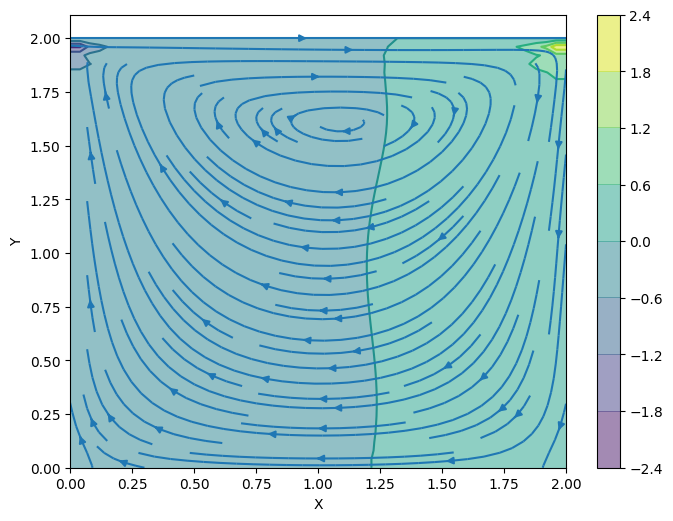

Vicosity =  0.01


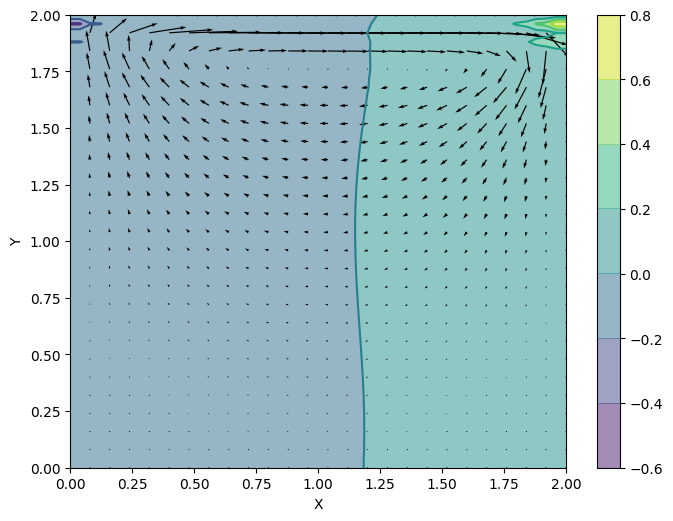

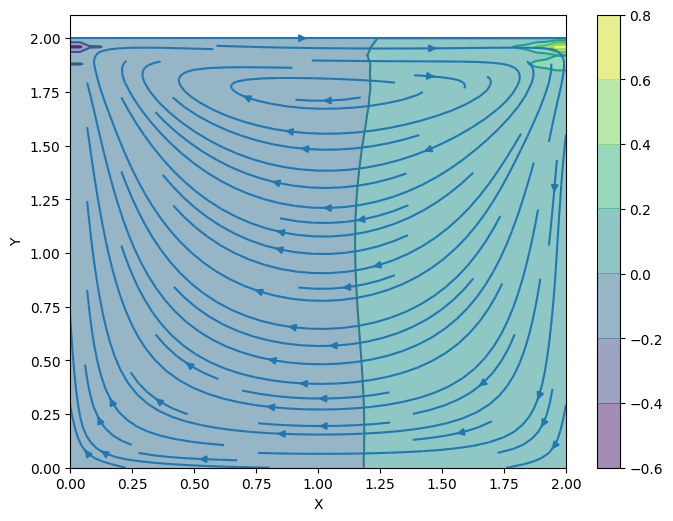

Vicosity =  0.005


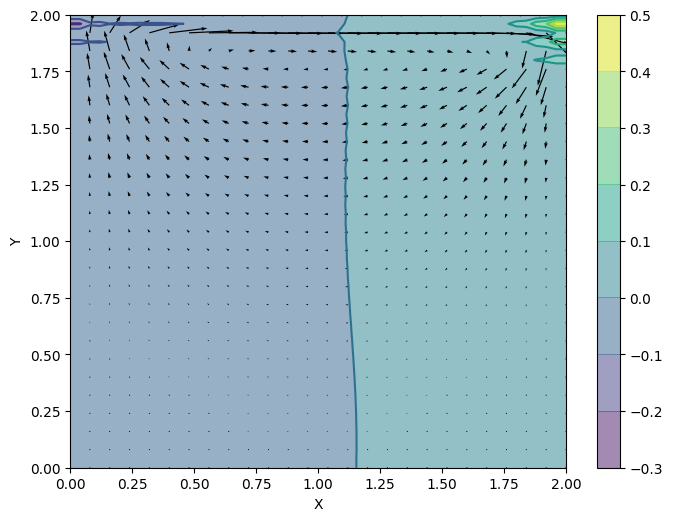

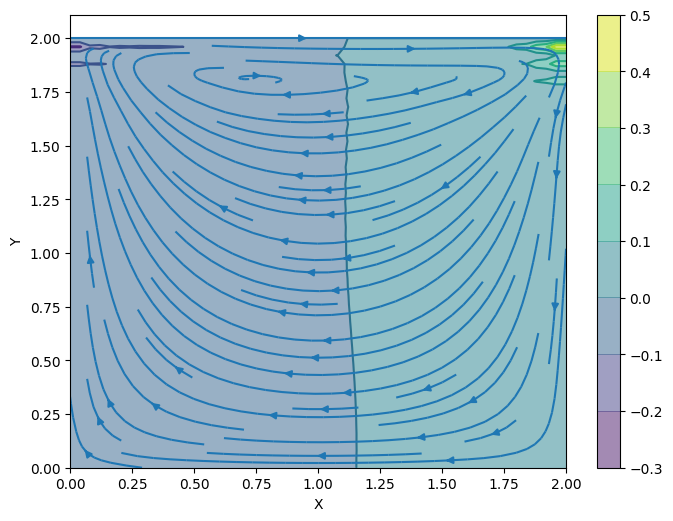

In [10]:
#Task 3 - Changing parameters

#part 1: changing viscosities
#initialize the system
rho = 1
nus = [0.1, 0.05, 0.01, 0.005]
xl = 2
yl = 2
nx = 51
ny = 51
dt = 0.001
cavity_space = Spacetime(xl, yl, nx, ny, dt)
waters = []
cavities = []

#boundary conditions
Dir_0 = Boundary("D", 0)
Dir_1 = Boundary("D", 1)
Neu_0 = Boundary("N", 0)

u_boundaries = [Dir_0, Dir_0, Dir_1, Dir_0]
v_boundaries = [Dir_0, Dir_0, Dir_0, Dir_0]
p_boundaries = [Neu_0, Neu_0, Dir_0, Neu_0]

#create the fluid systems
for nu_ in nus:
  water = Fluid(rho, nu_)
  waters.append(water)
  cavities.append(CFD_System(cavity_space, water, u_boundaries, 
                             v_boundaries, p_boundaries))

#update and visualize the systems
for i in range(1000):
  for j in range(len(cavities)):
    cavities[j].update()

for i in range(len(cavities)):
  print('Vicosity = ', nus[i])
  cavities[i].vis_quiver()
  cavities[i].vis_stream()

From the above figures, we see that the pressure gradient decreases drastically as we decrease the values of viscosity. We also see that as the viscosity decreases, the velocity of the fluid in lower region also decreases. As discussed in class, viscosity can be thought of as efficiency of energy transfer. Lower the viscosity, lower the energy transferred. Hence, we need more time and faster lid velocity to achieve the same velocity of fluid in the lower region.

Lid Velocity =  2


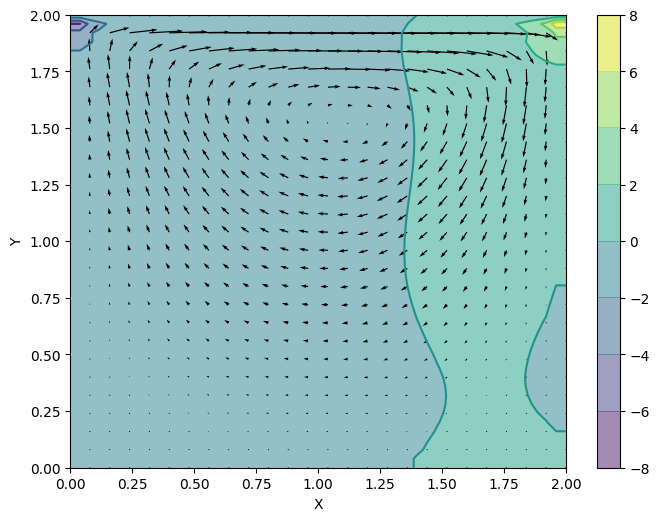

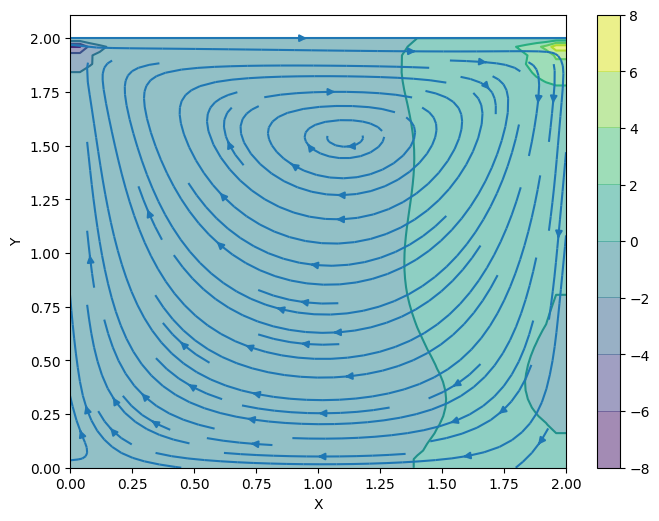

Lid Velocity =  4


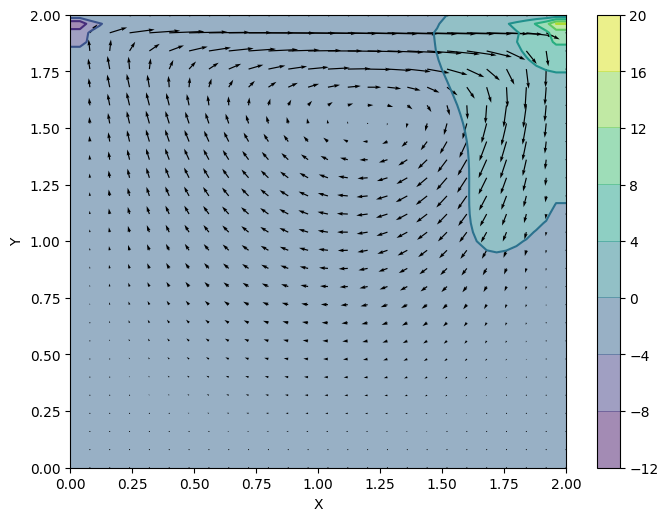

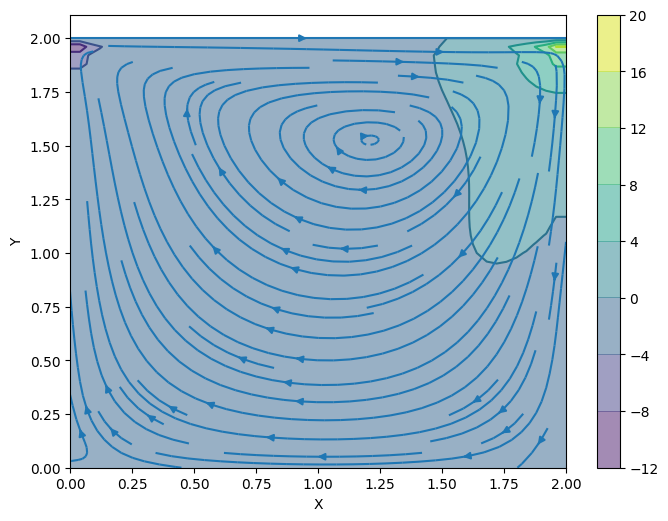

Lid Velocity =  6


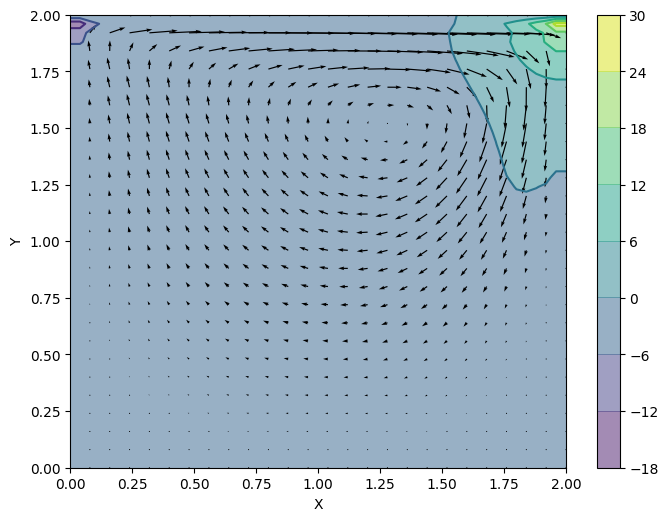

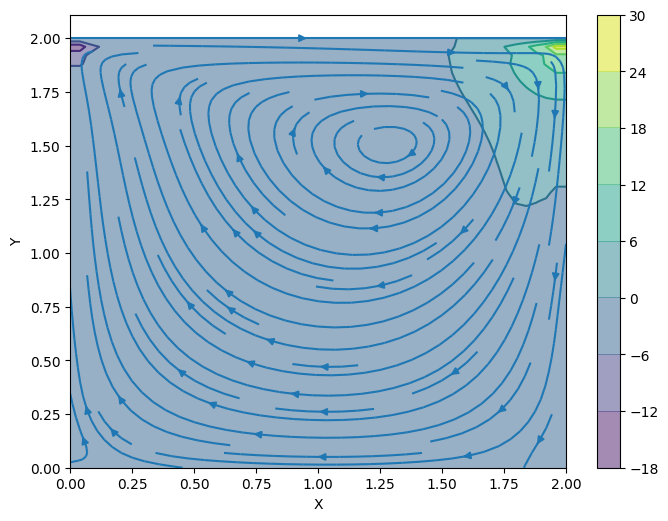

Lid Velocity =  8


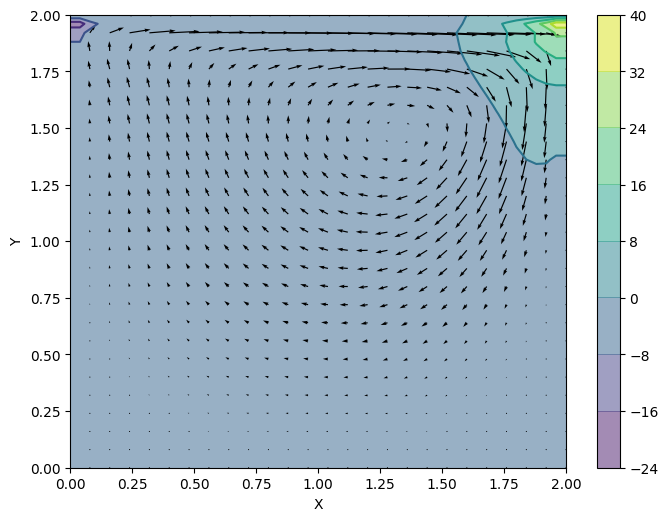

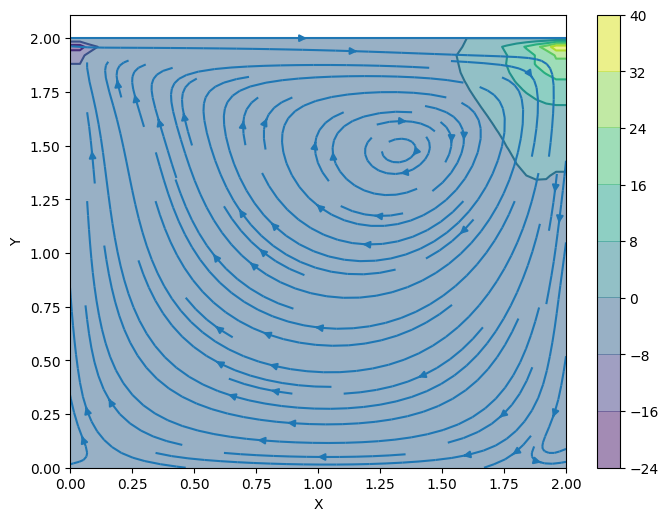

In [9]:
#part 2: changing lid velocities
#initialize the system
nu = 0.1
cavity_space = Spacetime(xl, yl, nx, ny, dt)
water = Fluid(rho, nu)
cavities = []
vs = [2, 4, 6, 8]

#boundary conditions
Dir_0 = Boundary("D", 0)
Dir_2 = Boundary("D", 2)
Dir_4 = Boundary("D", 4)
Dir_6 = Boundary("D", 6)
Dir_8 = Boundary("D", 8)
Neu_0 = Boundary("N", 0)

u_boundaries2 = [Dir_0, Dir_0, Dir_2, Dir_0]
u_boundaries4 = [Dir_0, Dir_0, Dir_4, Dir_0]
u_boundaries6 = [Dir_0, Dir_0, Dir_6, Dir_0]
u_boundaries8 = [Dir_0, Dir_0, Dir_8, Dir_0]
u_boundaries = [u_boundaries2, u_boundaries4, u_boundaries6, u_boundaries8]
v_boundaries = [Dir_0, Dir_0, Dir_0, Dir_0]
p_boundaries = [Neu_0, Neu_0, Dir_0, Neu_0]

#create the fluid systems
for u in u_boundaries:
  cavities.append(CFD_System(cavity_space, water, u, v_boundaries, 
                             p_boundaries))

#update and visualize the systems
for i in range(1000):
  for j in range(len(cavities)):
    cavities[j].update()

for i in range(len(cavities)):
  print('Lid Velocity = ', vs[i])
  cavities[i].vis_quiver()
  cavities[i].vis_stream()

From the figures above, we see that the regions of negative pressure become increasingly large as the velocities increase. We also see an increase in pressure gradient from one end to another. We also start to see regions of opposite flow forming in the corners. These may develop further for longer time scales to form vortices.


Since Reynold's number is defined as $U_{lid}L/ν$, increasing the velocity increases the Reynold's number and decreasing the viscosity also increases Re. 


In all the above cases, we had the lowest Re when $U_{lid} = 1$ and $ν = 0.1$ which was Re = 20. As we decreased the viscosity, our Re increased up to Re = 400. Whereas, when we increased the lid velocity, we only increased it by factors of 2. Hence, the highest Reynold's number we had was 80. Using all the information I gathered, it is pretty hard to tell the affect of Re on the fluid flow. From my simulation, it seems that decreasing the viscosity i.e. increasing the Re makes the fluid flow such that the pressure gradient is very low, and hence, it will be very hard to form a turbulent flow. therefore, the fluid flow has low vorticity when the viscosity is reduced. But, at the same time, when the lid velocity is increased, i.e., when the Re is increased, the pressure gradient increases, the regions of high pressure become larger, and we see small sections of opposite flow i.e. eddies forming. we also see that the fluid flow had high vorticity i.e. a larger curl. This second observations seems to be more in line with what is supposed to happen when you increase the reynold's number. I am not sure why that does not happen when we decrease viscosity in my simulation. Maybe I did not run the simulation for long enough?